In [1]:
library(ggvenn)
library(tidyverse)
library(RColorBrewer)
library(eulerr)
library(ggplotify)

# Custom package
library(rutils)

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: grid

Loading required package: ggplot2

-- Attaching packages ------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.6     v purrr   0.3.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
# hub_con_thresh <- 0.5
# hub_con_thresh <- 0.25
hub_con_thresh <- 0.0

In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("CESC", "UCS", "UCEC")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [4]:
demg_files <- paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets, "_demg_list.txt")
umsmg_files <- paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets, "_umsmg_list.txt")
nsmg_files <- paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets, "_nsmg_hub_thresh_", hub_con_thresh, "_list.txt")

# dge_m_files <- paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets, "_dge_m_gene_list.txt")
# univar_figo_files <- paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets, "_figo_univar_gene_list.txt")
# network_figo_files <- paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets, "_figo_network_hub_thresh_", hub_con_thresh, "_gene_list.txt")

In [5]:
text_size <- 11
guide_size <- 1
family <- "arial"
dpi <- 320
vd_ht <- 4
vd_wd <- vd_ht

In [6]:
# dge_m_lists <- list()
# univar_figo_lists <- list()
# network_figo_lists <- list()
demg_lists <- list()
umsmg_lists <- list()
nsmg_lists <- list()

for (i in 1:3) {
    demg_lists[[unified_dsets[i]]] <- read_lines(demg_files[i])
    umsmg_lists[[unified_dsets[i]]] <- read_lines(umsmg_files[i])
    nsmg_lists[[unified_dsets[i]]] <- read_lines(nsmg_files[i])
}
matrisome_df <- load_matrisome_df(matrisome_path)


-- Column specification ------------------------------------------------------------------------------------------------------------------------
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)




In [7]:
venn_df <- tibble(geneID = matrisome_df$gene_symbol) %>%
    # DEMGs
    dplyr::mutate(cesc_demg = geneID %in% demg_lists$unified_cervical_data) %>%
    dplyr::mutate(ucs_demg = geneID %in% demg_lists$unified_uterine_data) %>%
    dplyr::mutate(ucec_demg = geneID %in% demg_lists$unified_uterine_endometrial_data) %>%
    # Univar
    dplyr::mutate(cesc_umsmg = geneID %in% umsmg_lists$unified_cervical_data) %>%
    dplyr::mutate(ucs_umsmg = geneID %in% umsmg_lists$unified_uterine_data) %>%
    dplyr::mutate(ucec_umsmg = geneID %in% umsmg_lists$unified_uterine_endometrial_data) %>%
    # Network
    dplyr::mutate(cesc_nsmg = geneID %in% nsmg_lists$unified_cervical_data) %>%
    dplyr::mutate(ucs_nsmg = geneID %in% nsmg_lists$unified_uterine_data) %>%
    dplyr::mutate(ucec_nsmg = geneID %in% nsmg_lists$unified_uterine_endometrial_data)

In [8]:
venn_pal <- brewer.pal(n = 3, name = "Set2")
# venn_pal <- c("#F8766D", "#00BA38", "#619CFF")

In [9]:
make_inter_venn <- function (df, map, title = "") {
    ggplot(data = df) +
        geom_venn(
            map,
            fill_color = venn_pal,
            fill_alpha = 0.7,
            set_names = c("CESC", "UCS", "UCEC"),
            show_percentage = FALSE
        ) +
        theme_void() +
        theme(
            text = element_text(size = text_size, family = family)
#             plot.title = element_text(face = "bold", size = label_size)
        )
}

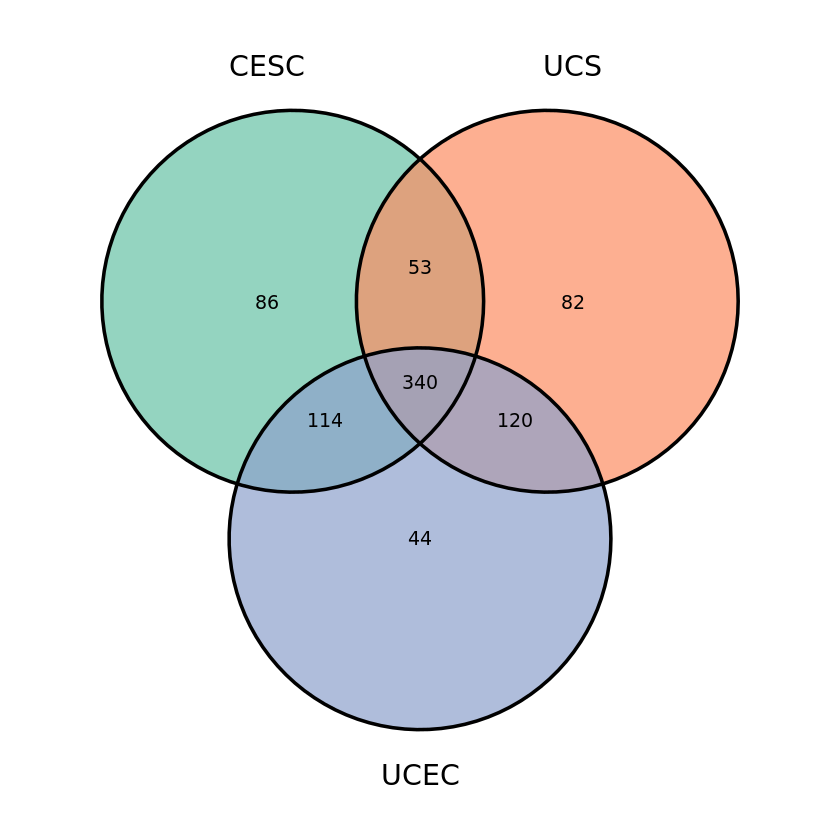

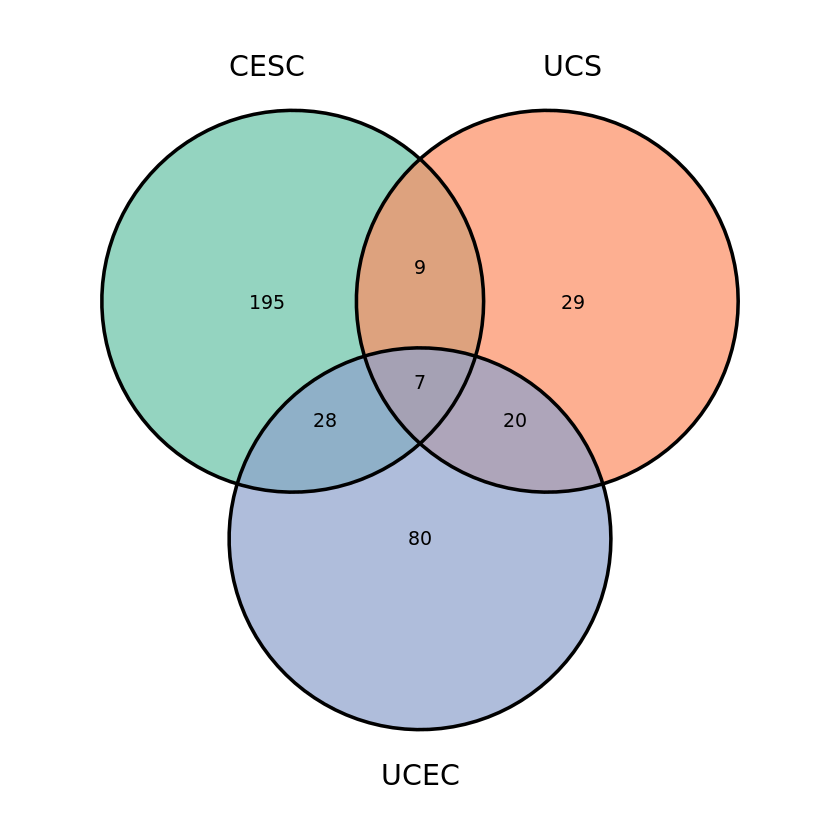

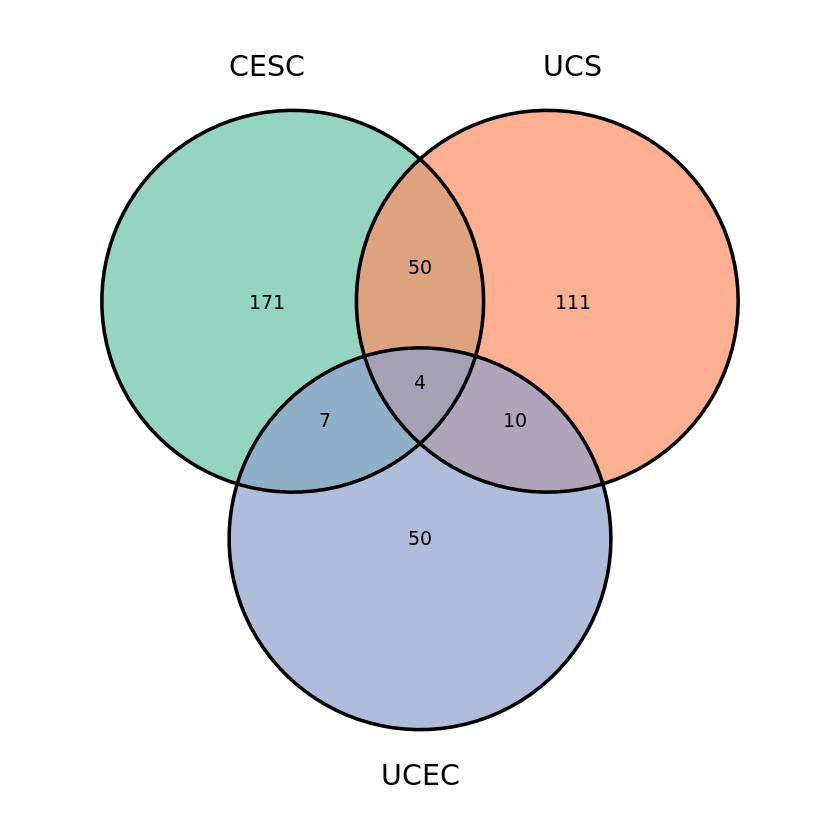

In [10]:
make_inter_venn(venn_df, aes_string(A = "cesc_demg", B = "ucs_demg", C = "ucec_demg"), title = "DEMG Overlaps")
ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/demg_inter_overlap_venn.png"), last_plot(), height = vd_ht, width = vd_wd)
make_inter_venn(venn_df, aes_string(A = "cesc_umsmg", B = "ucs_umsmg", C = "ucec_umsmg"), title = "UMSMG Overlaps")
ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/umsmg_inter_overlap_venn.png"), last_plot(), height = vd_ht, width = vd_wd)
make_inter_venn(venn_df, aes_string(A = "cesc_nsmg", B = "ucs_nsmg", C = "ucec_nsmg"), title = "NSMG Overlaps")
ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/nsmg_inter_overlap_venn.png"), last_plot(), height = vd_ht, width = vd_wd)

In [11]:
make_inter_euler <- function(venn_df, suffix) {
    demg_euler_df <- venn_df %>%
    column_to_rownames("geneID") %>%
    dplyr::select(ends_with(suffix)) %>%
    dplyr::rename_with(~ gsub(paste0("_", suffix), "", .)) %>%
    dplyr::rename_with(~ toupper(.))
    set.seed(123)
    
    euler(demg_euler_df, shape = "ellipse")
}


In [12]:
eulerr_options(labels = list(fontsize = text_size, fontface = 1))

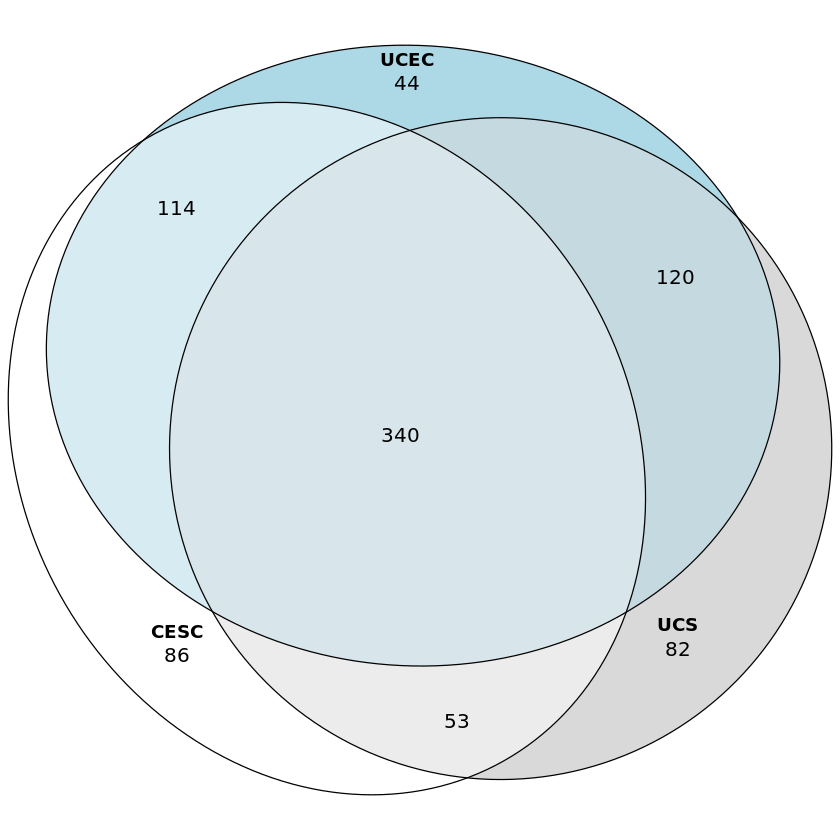

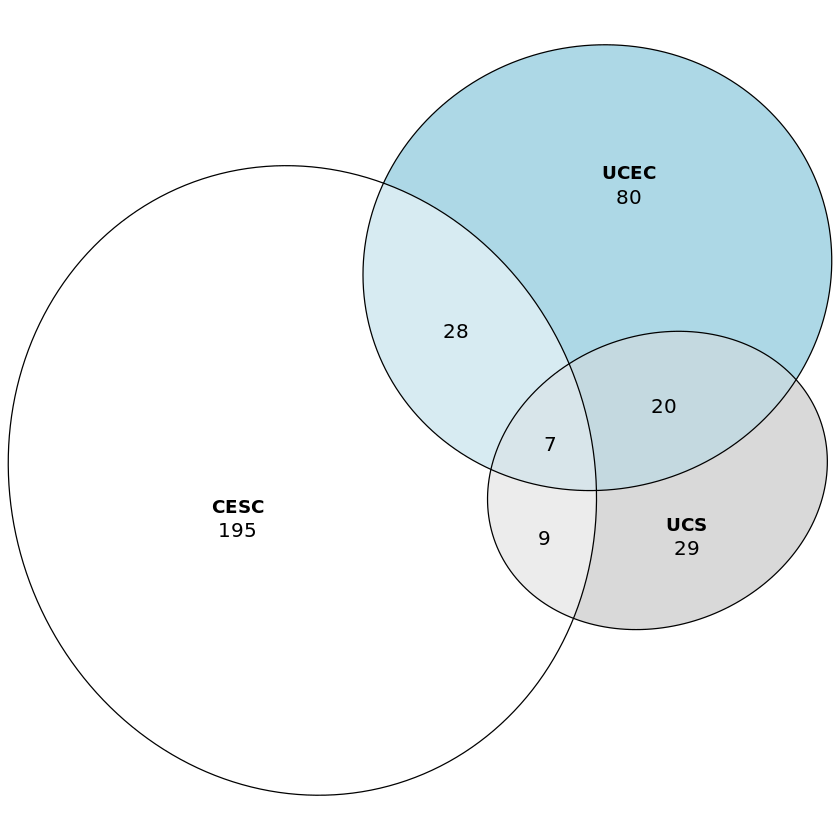

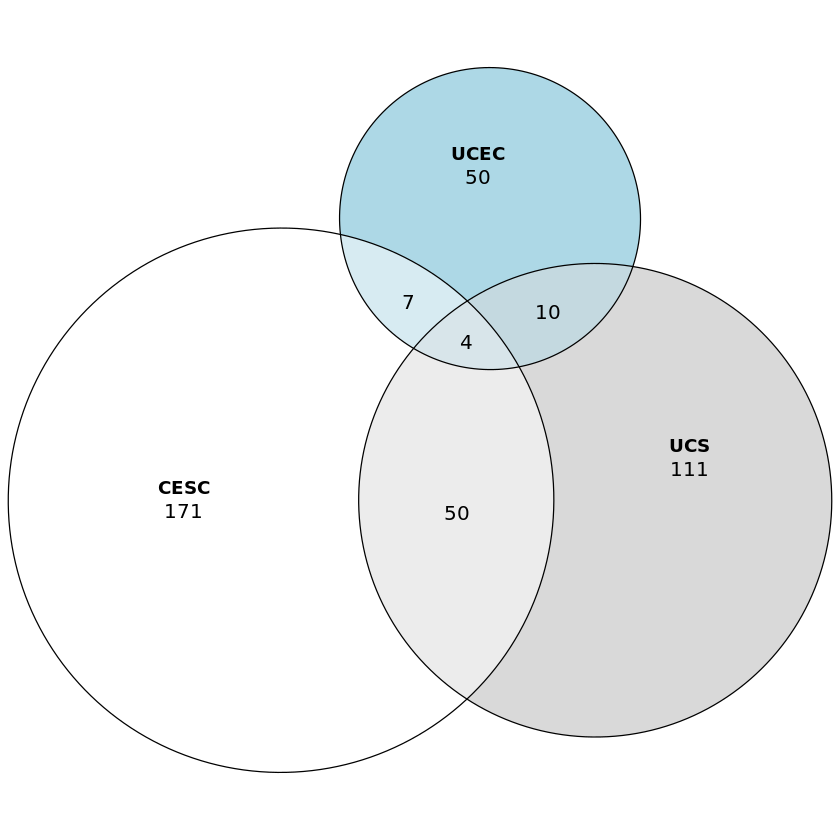

In [13]:
demg_euler_fit <- make_inter_euler(venn_df, "demg")
plot(demg_euler_fit, quantities = TRUE) %>% as.ggplot()
ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/demg_inter_overlap_euler.png"), last_plot(), height = vd_ht, width = vd_wd)

umsmg_euler_fit <- make_inter_euler(venn_df, "umsmg")
plot(umsmg_euler_fit, quantities = TRUE) %>% as.ggplot()
ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/umsmg_inter_overlap_euler.png"), last_plot(), height = vd_ht, width = vd_wd)

nsmg_euler_fit <- make_inter_euler(venn_df, "nsmg")
plot(nsmg_euler_fit, quantities = TRUE) %>% as.ggplot()
ggsave(filename = paste0(dirs$figures_dir, "/gene_lists/nsmg_inter_overlap_euler.png"), last_plot(), height = vd_ht, width = vd_wd)